In [ ]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

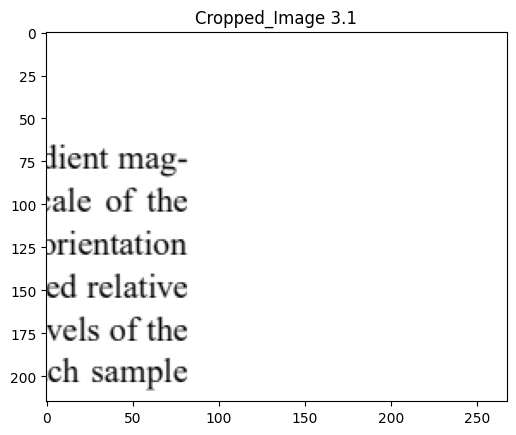

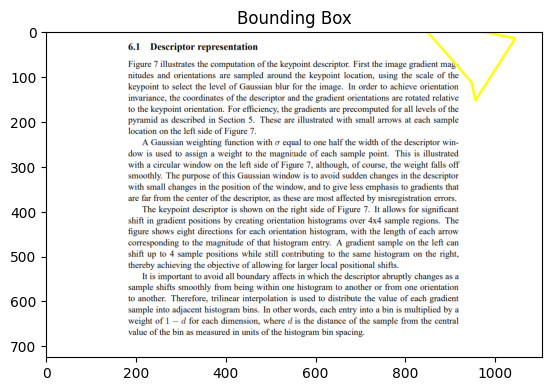

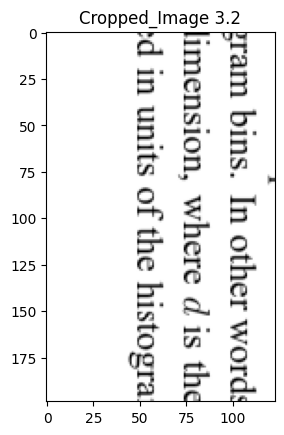

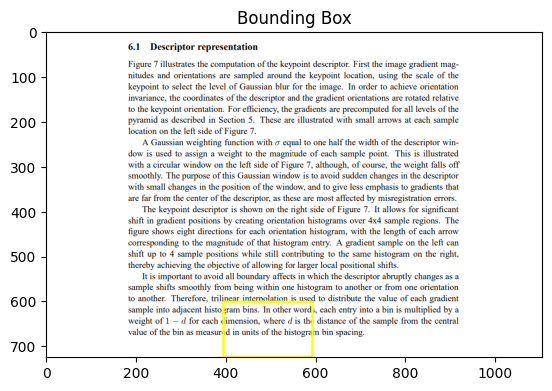

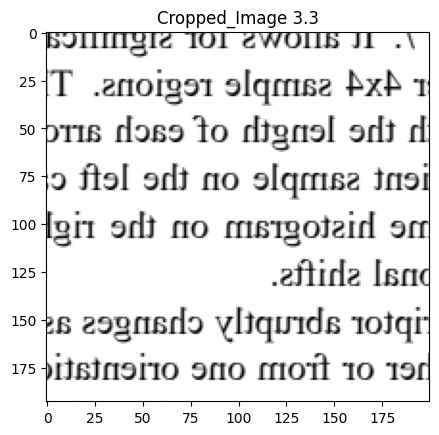

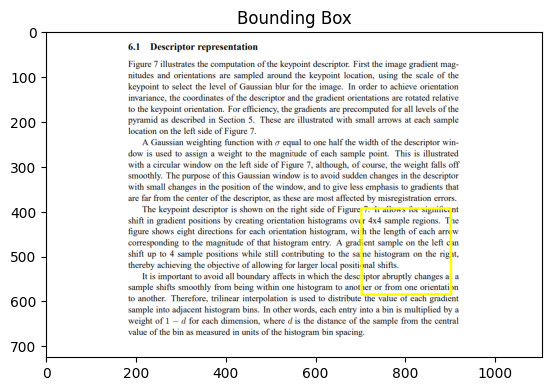

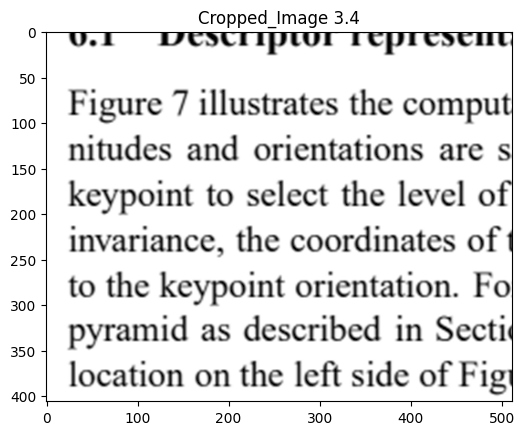

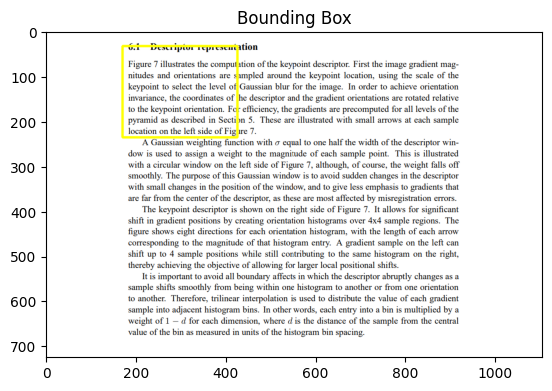

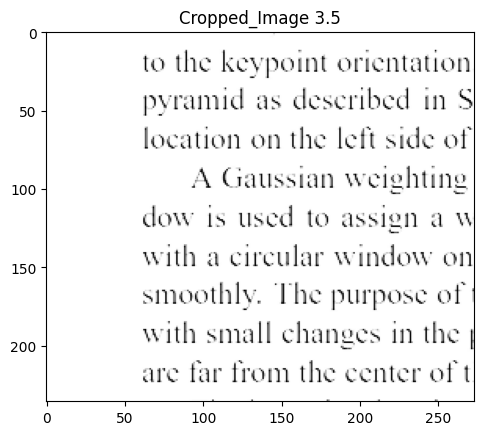

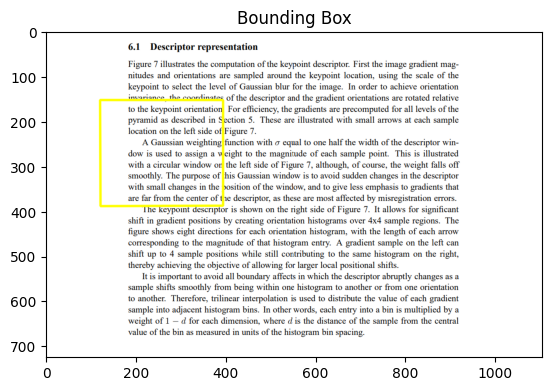

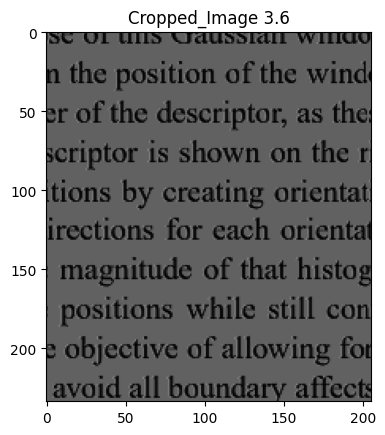

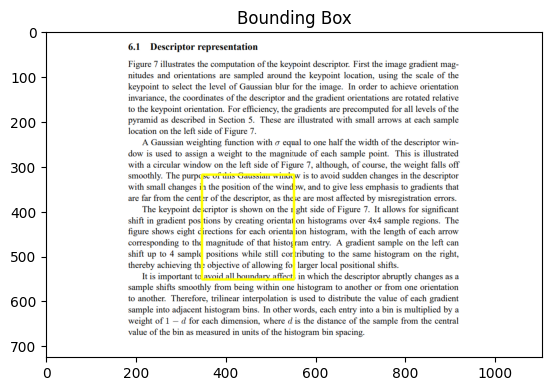

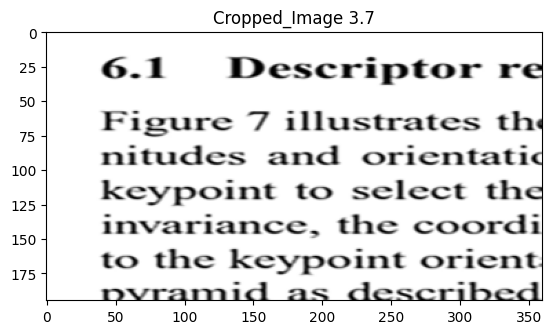

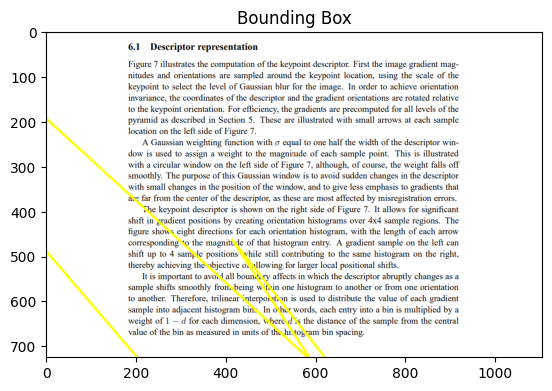

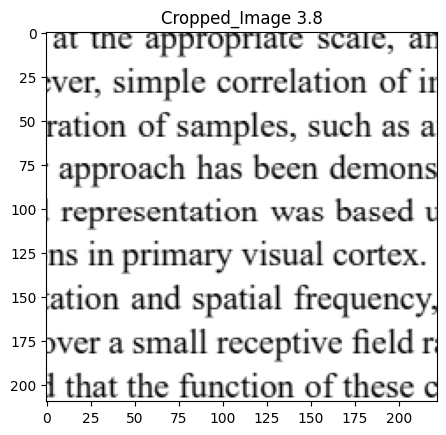

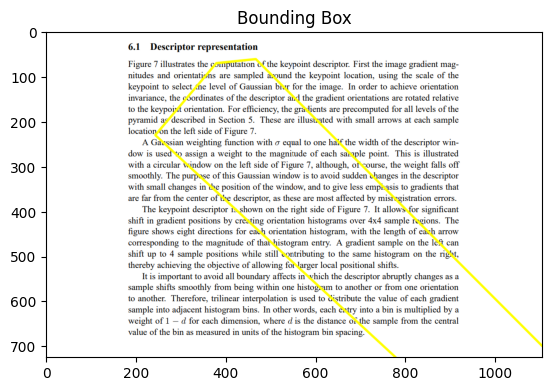

In [ ]:
def detect_keypoints_and_descriptors(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, np.float32(descriptors) if descriptors is not None else None

def match_keypoint_descriptors(descriptors1, descriptors2):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    return good_matches

def find_homography_and_bbox(keypoints1, keypoints2, good_matches, cropped_image_shape):
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    homography_matrix, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
    cropped_image_height, cropped_image_width = cropped_image_shape[:2]
    points = np.float32([[0, 0], [0, cropped_image_height - 1], [cropped_image_width - 1, cropped_image_height - 1], [cropped_image_width - 1, 0]]).reshape(-1, 1, 2)
    transformed_points = cv2.perspectiveTransform(points, homography_matrix)

    return transformed_points

def SIFT(original_image, cropped_image):
    cropped_image_transformations = [cropped_image, cv2.flip(cropped_image, 1)]

    keypoints_original, descriptors_original = detect_keypoints_and_descriptors(original_image)

    best_match = None
    max_good_matches = 0
    best_transformed_points = None

    for transformed_image in cropped_image_transformations:
        keypoints_transformed, descriptors_transformed = detect_keypoints_and_descriptors(transformed_image)
        if descriptors_transformed is None:
            continue
        good_matches = match_keypoint_descriptors(descriptors_original, descriptors_transformed)
        if len(good_matches) > max_good_matches:
            max_good_matches = len(good_matches)
            best_match = good_matches
            best_transformed_points = find_homography_and_bbox(keypoints_original, keypoints_transformed, good_matches, cropped_image.shape)

    if best_transformed_points is not None and len(best_match) > 10:
        return best_transformed_points, best_match
    else:
        return None, best_match

idxs = []
sift_bboxes = []
for i, cropped_image in enumerate(cropped_images):
    dst, matches = SIFT(original_image, cropped_image)
    if dst is not None:
        idxs.append(i + 1)
        sift_bboxes.append(dst)
for idx, sift_bbox in zip(idxs, sift_bboxes):
    original_image_hog = cv2.imread('data\\3.0.png')
    original_image_hog = draw_bboxes(original_image_hog, sift_bbox, (0, 255, 255))
    plt.imshow(cv2.cvtColor(cropped_images[idx - 1], cv2.COLOR_BGR2RGB))
    plt.title(f'Cropped_Image 3.{idx}')
    plt.show()
    plt.imshow(cv2.cvtColor(original_image_hog, cv2.COLOR_BGR2RGB))
    plt.title('Bounding Box')
    plt.show()
    print('\n\n')